# iCAT Overlay
---
Notebook for computing the FM <--> big EM overlay based on Odemis metadata. Creates the FM overlay stack. Can optionally use landmark registration matrices as substitute for Odemis metadata.

## 1
---
### 1.0 Imports

In [1]:
import re
from random import sample
from pathlib import Path

import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as Soup
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.filters import gaussian
from skimage.color import rgb2grey, grey2rgb
from skimage.external.tifffile import TiffFile
from skimage.transform import AffineTransform as AffineSkimage

import renderapi
from renderapi.tilespec import TileSpec, Layout
from renderapi.transform import AffineModel as AffineRender

from parse_metadata import parse_metadata

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_colwidth', -1)

### 1.1 Set up `render` environment

In [3]:
owner = 'rlane'  # replace with your name
project = '20190517_UMCG_RL005'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}

render = renderapi.connect(**render_connect_params)
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
CLEM_stacks = ['hoechst', 'big_EM']
CLEM_stacks = [stack for stack in CLEM_stacks if stack in stacks]

out = f"""\
project....... {project}
stacks........ {stacks}
CLEM_stacks... {CLEM_stacks}
"""

print(out)

project....... 20190517_UMCG_RL005
stacks........ ['lil_EM_montaged', 'lil_EM', 'hoechst', 'big_EM']
CLEM_stacks... ['hoechst', 'big_EM']



In [4]:
tile_spec_cols = ['tileId', 'z', 'width', 'height',
                  'minIntensity', 'maxIntensity',
                  'filepath', 'layout', 'transforms']
stack_data = pd.DataFrame(columns=['stack', 'section'] + tile_spec_cols)

i = 0
for stack in stacks:
    
    # Get z values for each stack
    z_vals = renderapi.stack.get_z_values_for_stack(stack, render=render)
    # Loop through z values
    for z in z_vals:
        
        # Get sectionId for z value
        section = renderapi.stack.get_sectionId_for_z(stack=stack,
                                                      z=z,
                                                      render=render)
        # Iterate through `TileSpec`s
        tile_specs = renderapi.tilespec.get_tile_specs_from_z(stack=stack,
                                                              z=z,
                                                              render=render)
        for ts in tile_specs:
            
            # Build up stack data
            stack_data.loc[i] = pd.Series(ts.to_dict())
            stack_data.loc[i, 'stack'] = stack
            stack_data.loc[i, 'section'] = section
            stack_data.loc[i, 'filepath'] = Path(ts.ip['0'].imageUrl.split('://')[1])

            # Increment index
            i += 1
            
# Add col, row data
stack_data['imageCol'] = stack_data.loc[:, 'layout'].apply(lambda x: x['imageCol'])
stack_data['imageRow'] = stack_data.loc[:, 'layout'].apply(lambda x: x['imageRow'])
stack_data['ColRow'] = [tuple(cr) for cr in stack_data[['imageCol', 'imageRow']].values.tolist()]

# Preview
stack_data = stack_data.infer_objects()
stack_data.groupby(['stack', 'section']).apply(lambda x: x.sample(3))

stack section  \
stack           section                                 
big_EM          S001    2380  big_EM           S001     
                        2379  big_EM           S001     
                        2381  big_EM           S001     
hoechst         S001    2369  hoechst          S001     
                        2360  hoechst          S001     
                        2374  hoechst          S001     
lil_EM          S001    1827  lil_EM           S001     
                        1484  lil_EM           S001     
                        2010  lil_EM           S001     
lil_EM_montaged S001    570   lil_EM_montaged  S001     
                        1095  lil_EM_montaged  S001     
                        790   lil_EM_montaged  S001     

                                                    tileId    z   width  \
stack           section                                                   
big_EM          S001    2380  aae_big_EM-S001-00003x00002   1.0  4096.0   
                        2379  aad_big_EM-S001-00003x00003   1.0  4096.0   
                        2381  aaf_big_EM-S001-00002x00002   1.0  4096.0   
hoechst         S001    2369  aaj_hoechst-S001-00001x00001  1.0  2048.0   
                        2360  aaa_hoechst-S001-00000x00003  1.0  2048.0   
                        2374  aao_hoechst-S001-00001x00000  1.0  2048.0   
lil_EM          S001    1827  ayx_lil_EM-S001-00013x00016   1.0  4096.0   
                        1484  als_lil_EM-S001-00008x00025   1.0  4096.0   
                        2010  bfy_lil_EM-S001-00034x00010   1.0  4096.0   
lil_EM_montaged S001    570   avy_lil_EM-S001-00018x00018   1.0  4096.0   
                        1095  bqd_lil_EM-S001-00025x00002   1.0  4096.0   
                        790   bek_lil_EM-S001-00010x00012   1.0  4096.0   

                              height  minIntensity  maxIntensity  \
stack           section                                            
big_EM          S001    2380  4096.0  0.0           65535.0        
                        2379  4096.0  0.0           65535.0        
                        2381  4096.0  0.0           65535.0        
hoechst         S001    2369  2048.0  1075.0        4738.5         
                        2360  2048.0  1075.0        4738.5         
                        2374  2048.0  1075.0        4738.5         
lil_EM          S001    1827  4096.0  0.0           65535.0        
                        1484  4096.0  0.0           65535.0        
                        2010  4096.0  0.0           65535.0        
lil_EM_montaged S001    570   4096.0  0.0           65535.0        
                        1095  4096.0  0.0           65535.0        
                        790   4096.0  0.0           65535.0        

                                                                                                                      filepath  \
stack           section                                                                                                          
big_EM          S001    2380  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/big_EM/big_EM-00003x00002.tif     
                        2379  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/big_EM/big_EM-00003x00003.tif     
                        2381  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/big_EM/big_EM-00002x00002.tif     
hoechst         S001    2369  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00001x00001.tif   
                        2360  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00000x00003.tif   
                        2374  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00001x00000.tif   
lil_EM          S001    1827  /long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/lil_EM/lil_EM-00013x00016.tif     
                        1484  /long_term_storage/rlane/SECOM/projec

### 1.2

In [5]:
def get_tform_metadata(filepath):
    """Parse Odemis (single-page) tiff file for transformation data
    
    Parameters
    ----------
    filepath : `Path`
        Path to image file
    
    Returns
    -------
    pixelsize : float
        Image pixel size [m]
    rotation : float
        Image rotation angle [rad]
    shear : float
        Image shear [?]
    """
    # Gather metadata as `Soup`
    tif = TiffFile(filepath.as_posix())
    metadata = tif.pages[0].image_description
    soup = Soup(metadata, 'lxml')
        
    # Calculate pixel size in x & y
    md = soup.pixels
    psx = 1e-6 * float(md['physicalsizex'])  # um --> m
    psy = 1e-6 * float(md['physicalsizey'])  # um --> m
    pixelsize = (psx, psy)
    
    # Parse out rotation matrix
    md = soup.transform
    A00 = float(md['a00'])  #  /         \
    A01 = float(md['a01'])  # | a00  a01 |
    A10 = float(md['a10'])  # | a10  a11 |
    A11 = float(md['a11'])  # \         /
    # QR decomposition into Rotation and Scale matrices
    A = np.array([[A00, A10],
                  [A01, A11]])
    R, S = np.linalg.qr(A)
    mask = np.diag(S) < 0.
    R[:, mask] *= -1.
    S[mask, :] *= -1.
    # Calculate rotation angle and shear
    theta = np.arctan2(R[1, 0], R[0, 0])
    angle = theta % (2*np.pi)  # Odemis convention
    shear = S[0, 1] / S[0, 0]
    
    # Translation
    md = soup.plane
    x0 = float(md['positionx'])
    y0 = float(md['positiony'])
    translation = (x0, y0)
    
    return pixelsize, angle, shear, translation

### 1.3 Compute transforms
#### Test parser on randomly chosen CLEM tile

In [6]:
# Filter to CLEM layers only
layers_CLEM = stack_data[stack_data['stack'].isin(CLEM_stacks)]
# Choose random filepath from CLEM tiles
fp = layers_CLEM.sample(1)['filepath'].iloc[0]
ps, a, sh, tr = get_tform_metadata(fp)

out = f"""\
File.......... {fp.parent.name}/{fp.name}
Pixel size.... {ps}
Rotation...... {a}
Shear......... {sh}
Translation... {tr}
"""
print(out)

File.......... hoechst/hoechst-00000x00003.tif
Pixel size.... (1.10345319848832e-07, 1.10345319848832e-07)
Rotation...... 6.235835567559074
Shear......... 6.938893903907228e-18
Translation... (-0.000234734, -9.415e-05)



#### Aggregate transform data

In [7]:
tform_cols = ['pixelsize_x', 'pixelsize_y', 'angle', 'shear', 'translation_x', 'translation_y']
stack_data_cols = ['stack', 'section', 'z', 'tileId', 'filepath']

tform_df = pd.DataFrame(columns=tform_cols)
tform_df = pd.concat([tform_df, layers_CLEM[stack_data_cols].copy()], sort=True)
tform_df['imageCol'] = layers_CLEM.loc[:, 'layout'].apply(lambda x: x['imageCol'])
tform_df['imageRow'] = layers_CLEM.loc[:, 'layout'].apply(lambda x: x['imageRow'])
tform_df['ColRow'] = [tuple(cr) for cr in tform_df[['imageCol', 'imageRow']].values.tolist()]

for i, row in tform_df.iterrows():
    
    ps, a, sh, tr = get_tform_metadata(row['filepath'])
    
    tform_df.loc[i, ['pixelsize_x', 'pixelsize_y']] = ps
    tform_df.loc[i, 'angle'] = a
    tform_df.loc[i, 'shear'] = sh
    tform_df.loc[i, ['translation_x', 'translation_y']] = tr
    
# Preview data
tform_df[['stack', 'section', 'z', 'tileId', 'imageCol', 'imageRow', 'ColRow'] + tform_cols]

,stack,section,z,tileId,imageCol,imageRow,ColRow,pixelsize_x,pixelsize_y,angle,shear,translation_x,translation_y
2360,hoechst,S001,1.0,aaa_hoechst-S001-00000x00003,0,3,"(0, 3)",1.10345e-07,1.10345e-07,6.23584,6.93889e-18,-0.000234734,-9.415e-05
2361,hoechst,S001,1.0,aab_hoechst-S001-00001x00003,1,3,"(1, 3)",1.10345e-07,1.10345e-07,6.23584,6.93889e-18,-3.3215e-05,-9.4141e-05
2362,hoechst,S001,1.0,aac_hoechst-S001-00002x00003,2,3,"(2, 3)",1.10345e-07,1.10345e-07,6.23584,6.93889e-18,0.000168639,-9.40057e-05
2363,hoechst,S001,1.0,aad_hoechst-S001-00003x00003,3,3,"(3, 3)",1.10345e-07,1.10345e-07,6.23584,6.93889e-18,0.000370144,-9.39937e-05
2364,hoechst,S001,1.0,aae_hoechst-S001-00003x00002,3,2,"(3, 2)",1.10337e-07,1.10337e-07,6.23616,1.38778e-17,0.000370552,0.000107987
2365,hoechst,S001,1.0,aaf_hoechst-S001-00002x00002,2,2,"(2, 2)",1.10057e-07,1.10057e-07,6.23571,-6.93889e-18,0.000167976,0.000107527
2366,hoechst,S001,1.0,aag_hoechst-S001-00001x00002,1,2,"(1, 2)",1.10057e-07,1.10057e-07,6.23571,-6.93889e-18,-3.37146e-05,0.000107546
2367,hoechst,S001,1.0,aah_hoechst-S001-00000x00002,0,2,"(0, 2)",1.10057e-07,1.10057e-07,6.23571,-6.93889e-18,-0.000235445,0.000107602
2368,hoechst,S001,1.0,aai_hoechst-S001-00000x00001,0,1,"(0, 1)",1.09944e-07,1.09944e-07,6.23566,6.93889e-18,-0.00023575,0.000309373
2369,hoechst,S001,1.0,aaj_hoechst-S001-00001x00001,1,1,"(1, 1)",1.09944e-07,1.09944e-07,6.23566,6.93889e-18,-3.43164e-05,0.000309367


## 2 Compute relative transform
---
### 2.1 Parse Odemis metadata for transformation data

In [8]:
def get_relative_tform(fp_src, fp_tmp):
    """Computes the relative transform between two correlative tile images
    
    Parameters
    ----------
    fp_src : `Path`
        Filepath for source (FM) image
    fp_tmp : `Path`
        Filepath for template (big EM) image
    
    Returns
    -------
    tform : `skimage.transform.AffineTransform`
    """
    # Get transform metadata for source image
    tform_md = get_tform_metadata(fp_src)
    ps_src, rot_src, sh_src, tr_src = tform_md
    
    # Get transform metadata for template image
    tform_md = get_tform_metadata(fp_tmp)
    ps_tmp, rot_tmp, sh_tmp, tr_tmp = tform_md
    
    # Relative scale
    scale = (ps_src[0] / ps_tmp[0],
             ps_src[1] / ps_tmp[1])
    
    # Relative rotation
    rotation = rot_tmp - rot_src
    
    # Relative shear
    shear = sh_tmp - sh_src
    
    # Relative translation
    # TODO: not so sure (at all) about this
    tx = (tr_src[0] - tr_tmp[0]) / ps_src[0]
    ty = (tr_src[1] - tr_tmp[1]) / ps_src[1]
            
    h_src, w_src = imread(fp_src).shape
    h_tmp, w_tmp = imread(fp_tmp).shape
    
    ox, oy = (w_tmp/2, h_tmp/2)
    px, py = (-w_src/2 + tx, -h_src/2 + ty)
    
    qx = ox + np.cos(rotation) * (px - ox) - np.sin(rotation) * (py - oy)
    qy = oy + np.sin(rotation) * (px - ox) + np.cos(rotation) * (py - oy)
    
    translation = (qx, qy)
    
    tform = AffineSkimage(scale=scale,
                          rotation=rotation,
                          shear=shear,
                          translation=translation)
    
    return tform

### 2.2

In [9]:
def AT_skimage2render(at_skimage):
    """Converts `AffineSkimage` to `AffineRender`"""
    M = at_skimage.params
    at_render = AffineRender(M00=M[0,0], M01=M[0,1], B0=M[0,2],
                             M10=M[1,0], M11=M[1,1], B1=M[1,2])
    return at_render

In [10]:
FM_data = stack_data[stack_data['stack'] == 'hoechst'].copy()
FM_data['overlay_tform'] = None

for i, grp in tform_df.groupby('ColRow'):
    new = grp.set_index('stack')
    
    # Source = FM image
    fp_src = new.loc['hoechst', 'filepath']
    # Template = big EM image
    fp_tmp = new.loc['big_EM', 'filepath']
    
    rel_tform_skimage = get_relative_tform(fp_src, fp_tmp)
    rel_tform_render = AT_skimage2render(rel_tform_skimage)
    
    index_FM = grp[grp['stack'] == 'hoechst'].index
    
    FM_data.loc[index_FM, 'overlay_tform'] = rel_tform_render
    
FM_data.head()

,stack,section,tileId,z,width,height,minIntensity,maxIntensity,filepath,layout,transforms,imageCol,imageRow,ColRow,overlay_tform
2360,hoechst,S001,aaa_hoechst-S001-00000x00003,1.0,2048.0,2048.0,1075.0,4738.5,/long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00000x00003.tif,"{'sectionId': 'S001', 'temca': 'SECOM', 'camera': 'Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)', 'imageRow': 3, 'imageCol': 0, 'stageX': -234.734, 'stageY': -94.14999999999999, 'rotation': 0.0}","{'type': 'list', 'specList': [{'type': 'leaf', 'className': 'mpicbg.trakem2.transform.AffineModel2D', 'dataString': '1.0000000000 0.0000000000 0.0000000000 1.0000000000 19.8868989188 5502.5373374559'}]}",0,3,"(0, 3)","M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-875.152881,-1165.960988]"
2361,hoechst,S001,aab_hoechst-S001-00001x00003,1.0,2048.0,2048.0,1075.0,4738.5,/long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00001x00003.tif,"{'sectionId': 'S001', 'temca': 'SECOM', 'camera': 'Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)', 'imageRow': 3, 'imageCol': 1, 'stageX': -33.214999999999996, 'stageY': -94.141, 'rotation': 0.0}","{'type': 'list', 'specList': [{'type': 'leaf', 'className': 'mpicbg.trakem2.transform.AffineModel2D', 'dataString': '1.0000000000 0.0000000000 0.0000000000 1.0000000000 1846.1446892453 5502.4557753197'}]}",1,3,"(1, 3)","M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-875.152881,-1165.960988]"
2362,hoechst,S001,aac_hoechst-S001-00002x00003,1.0,2048.0,2048.0,1075.0,4738.5,/long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00002x00003.tif,"{'sectionId': 'S001', 'temca': 'SECOM', 'camera': 'Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)', 'imageRow': 3, 'imageCol': 2, 'stageX': 168.63904226, 'stageY': -94.00565527399999, 'rotation': 0.0}","{'type': 'list', 'specList': [{'type': 'leaf', 'className': 'mpicbg.trakem2.transform.AffineModel2D', 'dataString': '1.0000000000 0.0000000000 0.0000000000 1.0000000000 3675.4387865077 5501.2292192122'}]}",2,3,"(2, 3)","M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-872.153923,-1164.717966]"
2363,hoechst,S001,aad_hoechst-S001-00003x00003,1.0,2048.0,2048.0,1075.0,4738.5,/long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00003x00003.tif,"{'sectionId': 'S001', 'temca': 'SECOM', 'camera': 'Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)', 'imageRow': 3, 'imageCol': 3, 'stageX': 370.14404226, 'stageY': -93.99365527399999, 'rotation': 0.0}","{'type': 'list', 'specList': [{'type': 'leaf', 'className': 'mpicbg.trakem2.transform.AffineModel2D', 'dataString': '1.0000000000 0.0000000000 0.0000000000 1.0000000000 5501.5697024003 5501.1204696973'}]}",3,3,"(3, 3)","M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-872.153923,-1164.717966]"
2364,hoechst,S001,aae_hoechst-S001-00003x00002,1.0,2048.0,2048.0,1075.0,4738.5,/long_term_storage/rlane/SECOM/projects/20190517_UMCG_RL005/S001/hoechst/hoechst-00003x00002.tif,"{'sectionId': 'S001', 'temca': 'SECOM', 'camera': 'Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)', 'imageRow': 2, 'imageCol': 3, 'stageX': 370.552204562, 'stageY': 107.986578379, 'rotation': 0.0}","{'type': 'list', 'specList': [{'type': 'leaf', 'className': 'mpicbg.trakem2.transform.AffineModel2D', 'dataString': '1.0000000000 0.0000000000 0.0000000000 1.0000000000 5505.6597279597 3670.5526407709'}]}",3,2,"(3, 2)","M=[[3.029898,-0.159209],[0.142598,3.012846]] B=[-868.623563,-1159.644108]"


### 2.3 Optionally overwrite metadata-based transform with landmark-registration-based transform

In [11]:
lmrb_tform_data = {
    (0, 0): [3.0304197931453993, -0.02352464003243803, -0.15818292435611478, 2.9223281281687306, -896.6647738795273, -871.5392415331735],
    (1, 0): [3.0148701279645778, 0.13488226533306646, -0.13903533686436284, 3.0128424069098747, -892.2100241271644, -1194.341320404219],
    (2, 0): [3.008832721963365, 0.11926279264899015, -0.14039673260898558, 2.993045136956386, -878.8024844837914, -1149.375975889045],
    (3, 0): [3.0080305296146075, 0.12694919872969093, -0.12859648806192567, 3.0430538418450936, -892.9241851481011, -1237.2471561851576],
    (0, 1): [3.018234237999414, 0.11591319502503028, -0.14426712683963333, 3.0165003243001727, -878.8593249884899, -1166.272017390988],
    (1, 1): [3.017370022969888, 0.11836565965042202, -0.1456102116014411, 3.0183584929983636, -878.1337299685307, -1180.7015133119107],
    (2, 1): [3.0269171758827635, 0.13187303948304813, -0.1407166151972976, 3.014564403925736, -887.4536886221747, -1189.273866106587],
    (3, 1): [3.021762044848712, 0.12329951429409954, -0.14209652666000236, 3.0093518318987913, -879.7494078827024, -1176.5443096740296],
    (0, 2): [3.020048893071416, 0.12305814062859186, -0.14367499891595967, 3.0223821335640957, -889.3724696426148, -1172.951459808537],
    (1, 2): [3.012901777402516, 0.12641848955785445, -0.15212176664559915, 3.006261576823556, -868.3176698359468, -1168.8569763253854],
    (2, 2): [3.016753579862397, 0.1332989843099808, -0.14044508750186258, 3.0084498727538547, -880.0635903152854, -1183.4784417602466],
    (3, 2): [3.0264910549593798, 0.1317671204803212, -0.13560166484508165, 3.0151451879955014, -887.3054189221334, -1186.7239758802666],
    (0, 3): [3.031688660938902, 0.12187840899691256, -0.13597907593108688, 3.041670840192825, -910.430115371961, -1190.5025784969082],
    (1, 3): [3.0100748334246754, 0.12706788337320266, -0.14530708881683616, 3.0044901178472436, -886.5305018708559, -1164.3724563459486],
    (2, 3): [3.02231386170171, 0.13476973441018084, -0.1415540795428364, 3.016167228174629, -892.8863670174046, -1167.434135268621],
    (3, 3): [3, 0, 0, 3, -890, -1185]
}

lmrb_tforms = {}
for k, M in lmrb_tform_data.items():
    render_at = AffineRender(M00=M[0], M01=M[2], B0=M[4],
                             M10=M[1], M11=M[3], B1=M[5])
    lmrb_tforms[k] = render_at
    
    out = f"{k}: {render_at}"
    print(out)

(0, 0): M=[[3.030420,-0.158183],[-0.023525,2.922328]] B=[-896.664774,-871.539242]
(1, 0): M=[[3.014870,-0.139035],[0.134882,3.012842]] B=[-892.210024,-1194.341320]
(2, 0): M=[[3.008833,-0.140397],[0.119263,2.993045]] B=[-878.802484,-1149.375976]
(3, 0): M=[[3.008031,-0.128596],[0.126949,3.043054]] B=[-892.924185,-1237.247156]
(0, 1): M=[[3.018234,-0.144267],[0.115913,3.016500]] B=[-878.859325,-1166.272017]
(1, 1): M=[[3.017370,-0.145610],[0.118366,3.018358]] B=[-878.133730,-1180.701513]
(2, 1): M=[[3.026917,-0.140717],[0.131873,3.014564]] B=[-887.453689,-1189.273866]
(3, 1): M=[[3.021762,-0.142097],[0.123300,3.009352]] B=[-879.749408,-1176.544310]
(0, 2): M=[[3.020049,-0.143675],[0.123058,3.022382]] B=[-889.372470,-1172.951460]
(1, 2): M=[[3.012902,-0.152122],[0.126418,3.006262]] B=[-868.317670,-1168.856976]
(2, 2): M=[[3.016754,-0.140445],[0.133299,3.008450]] B=[-880.063590,-1183.478442]
(3, 2): M=[[3.026491,-0.135602],[0.131767,3.015145]] B=[-887.305419,-1186.723976]
(0, 3): M=[[3.03

In [12]:
FM_data['overwritten_tform'] = FM_data.loc[:, 'overlay_tform']

for k, render_at in lmrb_tforms.items():
    
    index_ = FM_data[FM_data['ColRow'] == k].index.values[0]
    FM_data.loc[index_, 'overlay_tform'] = render_at
    
FM_data[['overwritten_tform', 'overlay_tform']]

,overwritten_tform,overlay_tform
2360,"M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-875.152881,-1165.960988]","M=[[3.031689,-0.135979],[0.121878,3.041671]] B=[-910.430115,-1190.502578]"
2361,"M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-875.152881,-1165.960988]","M=[[3.010075,-0.145307],[0.127068,3.004490]] B=[-886.530502,-1164.372456]"
2362,"M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-872.153923,-1164.717966]","M=[[3.022314,-0.141554],[0.134770,3.016167]] B=[-892.886367,-1167.434135]"
2363,"M=[[3.030843,-0.161484],[0.143617,3.012170]] B=[-872.153923,-1164.717966]","M=[[3.000000,0.000000],[0.000000,3.000000]] B=[-890.000000,-1185.000000]"
2364,"M=[[3.029898,-0.159209],[0.142598,3.012846]] B=[-868.623563,-1159.644108]","M=[[3.026491,-0.135602],[0.131767,3.015145]] B=[-887.305419,-1186.723976]"
2365,"M=[[3.015408,-0.161405],[0.143280,3.011745]] B=[-874.553659,-1165.654977]","M=[[3.016754,-0.140445],[0.133299,3.008450]] B=[-880.063590,-1183.478442]"
2366,"M=[[3.015408,-0.161405],[0.143280,3.011745]] B=[-874.553659,-1165.654977]","M=[[3.012902,-0.152122],[0.126418,3.006262]] B=[-868.317670,-1168.856976]"
2367,"M=[[3.015408,-0.161405],[0.143280,3.011745]] B=[-874.553659,-1165.654977]","M=[[3.020049,-0.143675],[0.123058,3.022382]] B=[-889.372470,-1172.951460]"
2368,"M=[[3.009759,-0.157356],[0.143143,3.011387]] B=[-875.430404,-1164.275540]","M=[[3.018234,-0.144267],[0.115913,3.016500]] B=[-878.859325,-1166.272017]"
2369,"M=[[3.009759,-0.157356],[0.143143,3.011387]] B=[-875.430404,-1164.275540]","M=[[3.017370,-0.145610],[0.118366,3.018358]] B=[-878.133730,-1180.701513]"


## 3 Upload to `render`
---
### 3.1 Create FM overlay stack

In [13]:
# Create FM overlay `TileSpec`s
tile_specs = []
for i, tile in FM_data.iterrows():
    
    index_big_EM = stack_data[(stack_data['ColRow'] == tile['ColRow']) &\
                              (stack_data['stack'] == 'big_EM')].index.values[0]
    tile_big_EM = stack_data.loc[index_big_EM]
    tform_init_str_big_EM = tile_big_EM['transforms']['specList'][0]['dataString']
    T = np.array(tform_init_str_big_EM.split(' '), dtype=float)
    tform_init_big_EM = AffineRender(M00=T[0], M01=T[1], B0=T[4],
                                     M10=T[2], M11=T[3], B1=T[5])
    
    # Extract out overlay transform
    tform_overlay = tile['overlay_tform']
    # Listify transforms together
    tforms = [tform_overlay, tform_init_big_EM]
    
    # Create `TileSpec`
    ts = TileSpec(tileId=tile['tileId'],
                  z=int(tile['z']),
                  width=int(tile['width']),
                  height=int(tile['height']),
                  imageUrl=Path(tile['filepath']).as_uri(),
                  minint=int(tile['minIntensity']),
                  maxint=int(tile['maxIntensity']),
                  layout=Layout(**tile['layout']),
                  tforms=tforms)
    tile_specs.append(ts)

# Create stack
stack = 'hoechst_overlaid'
renderapi.stack.create_stack(stack=stack,
                             render=render)

# Import FM overlay `TileSpec`s
renderapi.client.import_tilespecs(stack=stack,
                                  tilespecs=tile_specs,
                                  render=render)

# Set stack state to COMPLETE
renderapi.stack.set_stack_state(stack=stack,
                                state='COMPLETE',
                                render=render);

### 3.2 Inspect

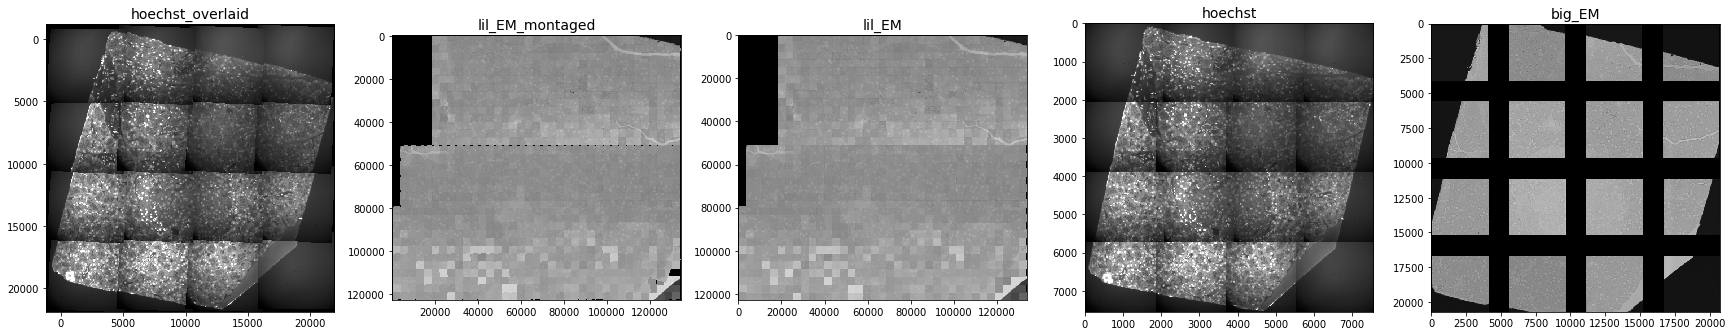

In [14]:
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
sections = stack_data['section'].unique().tolist()

for (z, section), layer in tqdm_notebook(stack_data.groupby(['z', 'section']), total=len(sections)):
    
    # Set up figure
    ncols = len(stacks)
    fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))
    
    for c, stack in tqdm_notebook(enumerate(stacks), total=len(stacks)):
        
        # Get section bounds
        bounds = renderapi.stack.get_bounds_from_z(stack=stack,
                                                   z=z,
                                                   render=render)
        
        # Fetch section image per stack
        scale = 512 / (bounds['maxX'] - bounds['minX'])
        image = renderapi.image.get_section_image(stack=stack,
                                                  z=z,
                                                  scale=scale,
                                                  render=render)
        
        # Plot image
        extent = [bounds[k] for k in ['minX', 'maxX', 'minY', 'maxY']]  # [left, right, bottom, top]
        axes[c].imshow(image, extent=extent, origin='lower')
        
        # Axis aesthetics
        axes[c].invert_yaxis()
        if z == stack_data['z'].min():
            axes[c].set_title(f'{stack}', fontsize=14)